## Setup

In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.backend import clear_session
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import shutil
from zipfile import ZipFile


## Generator model

In [120]:
model_path = './api/data/generator.h5' # generator100
def load_generator_model(model_path):
    model = keras.models.load_model(model_path)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),  # Low learning rate
        loss= keras.metrics.Mean(name="g_loss"),
    )
    return model

model_gen = load_generator_model(model_path)

In [121]:
batch_size = 32
latent_dim = 128

def generate_images(batch_size, latent_dim):
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    generated_images = model_gen.predict(random_latent_vectors)
    #generated_images *= 255
    #generated_images = generate_images.astype(int32)
    #print(generated_images.type, generated_images.shape)
    #imgs = np.array([keras.preprocessing.image.array_to_img(img) for img in generated_images])
    return generated_images

generated_images = generate_images(batch_size, latent_dim)
generated_images[0].shape

(128, 128, 3)

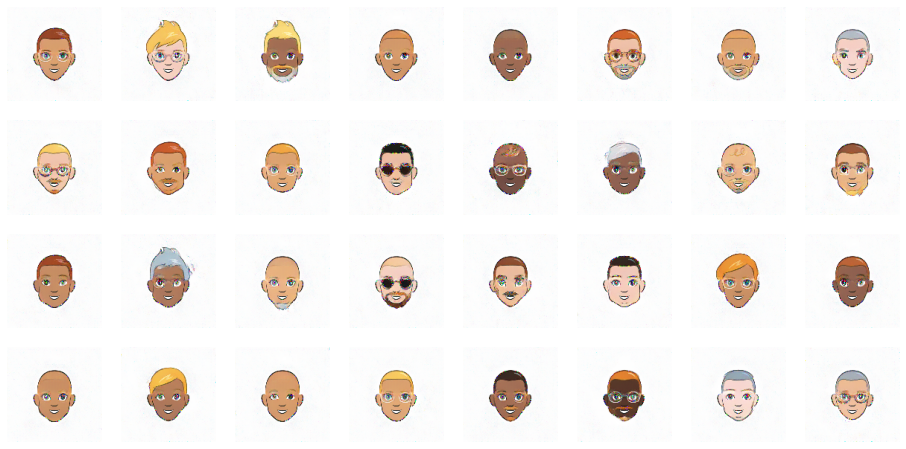

In [122]:
fig = plt.figure(figsize=[16, 8])
for i in range(batch_size):
    ax = plt.subplot(4, 8, i+1)
    plt.imshow((generated_images * 255).astype(np.uint8)[i])
    plt.axis("off")

## essai avec le model gan complet --> pas concluant pour l instant

In [47]:
#from PIL import Image
#img_data = np.random.random(size=(128, 128, 3))
#img = tf.keras.preprocessing.image.array_to_img(img_data)
#array = tf.keras.preprocessing.image.img_to_array(img)
#img_array = tf.expand_dims(array, 0)
#
#gan.train_on_batch(array)
#
#
#gan.load_weights('/home/anthony/Documents/Briefs/3_Block_mars_avril_deep\
#                    /20210323_Avatar_generator/api/data/gan.h5', by_name=True)

In [51]:
IMG_SIZE = 128

discriminator = keras.Sequential(
    [
        keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

latent_dim = 128
Dim_first_lay = int(IMG_SIZE/(2**3))
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(Dim_first_lay * Dim_first_lay * 128),
        layers.Reshape((Dim_first_lay, Dim_first_lay, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()


class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
            )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
            )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.build((128, 128, 3)) 
gan.load_weights('./api/data/gan.h5')

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)           

NotImplementedError: When subclassing the `Model` class, you should implement a `call` method.